In [2]:
import sys
!{sys.executable} -m pip install scipy

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats, optimize, interpolate
from scipy.optimize import fsolve
from scipy.integrate import odeint
from scipy.integrate import solve_bvp
from scipy.linalg import solve_banded
import time
start_time = time.time()
# main()
plt.rcParams.update({'font.size': 11})



In [8]:
#
# Define function cvi_nonlinear which computes resulting pore radius/gas concentration profiles as a function of CVI process parameters
#

def cvi_nonlinear(Tin,Pin, phi0in, rin, ain,dt,porin, phitolin, nzin): # Temperature, pressure, initial pore diameter, aspect ratio, phase ratio, line color, line label, time stepper, variable to plot (between rp and C). 
    
    
    ###
    # CVI CONDITIONS
    ###
    
    phi0 = phi0in     # Pore diameter, m  
    L = rin*phi0      # Length, m
    nz = nzin         # Number of grid points, dimensionless
    h = L/(nz-1)      # Distance between grid points, m
    hh = h**2
    dt = dt           # Time stepper, s

    phii = phi0*np.ones(nz)
    phi = phii
    
    Zrange = np.linspace(0,L/2,nz)           # Grid that represents length of specimen
    alpha = ain                            # Ratio between H2 and MTS concentrations at reactor entrance, dimensionless
    P = Pin                                # Pressure, Pa
    T = Tin                                # Temperature, K
    
    
    R = 8.314                              # Ideal gas constant, J/mol K
    
    CMTS0 = (1/(1+alpha))*(P / (R*T))      # MTS concentration at z=0 (BC), mol/m^3
    CH20 = (alpha/(1+alpha))*(P / (R*T))   # H2 concentration at z=0 (1-CMTS0), mol/m^3,  Fedou1993-2 Eqs. 9-10
    CHCl0 = 0                              # HCl concentration at z=0 (1-CMTS0), mol/m^3
    
    k0 = 3.89e9                            # Reaction rate coefficient, m/s
    Ea = 296e3                             # Activation energy, J/mol
    
    CMTS = CMTS0*np.ones(nz)
    CMTS[0] = CMTS0
    CH2 = CH20*np.ones(nz)                     # Gas phase composition at pore entrance, Fedou1993-2 Eqs. 9-10
    CH2[0] = CH20
    CHCl = CHCl0*np.ones(nz)
    CHCl[0] = CHCl0
    
    Ct0_before_penetration = [CMTS, CH2, CHCl]
    
    khet = k0*np.exp(-Ea/(R*T))
    # print('khet_fedou=',khet)
    
    
    #### Walker DFT paper
    # R = 8.617333262e-5
    # T = 1273
    # Ea = 0.918 #mean
    # # Ea = 0.493 #lower bound
    # # Ea = 1.342 #upper bound
    # khet = np.exp(-Ea/(R*T))
    # print("khet_walker=",khet)
    ####
    
    nu = khet*CMTS         # Kinetic law, Fedou1993-2 Eq. 3
    
    dKMTS = 3.97 #m/sK^(1/2)               # Reduced Knudsen coefficient of MTS, m/s K^1/2
    dKH2 = 34.30 #m/sK^(1/2)               # Reduced Knudsen coefficient of H2, m/s K^1/2,  Fedou1993-2 Table I
    dKHCl = 8.03 #m/sK^(1/2)               # Reduced Knudsen coefficient of HCl, m/s K^1/2
    
    DKMTS=dKMTS*phi*(T**0.5)              # Knudsen diffusion coefficient of MTS, m^2/s 
    DKH2=dKH2*phi*(T**0.5)                # Knudsen diffusion coefficient of H2, m^2/s,  Fedou1993-2 Eq. 2
    DKHCl=dKHCl*phi*(T**0.5)              # Knudsen diffusion coefficient of HCl, m^2/s 
    
    # MSiC = 0.04011                       # Molar mass of SiC, kg/mol
    MMTS = 0.149                             # Molar mass of MTS, kg/mol
    MH2 = 2e-3                             # Molar mass of H2, kg/mol,  Fedou1993-2 Table I
    MHCl = 3.65e-2                         # Molar mass of HCl, kg/mol
    
    # rhoSiC = 3217                        # Density of SiC, kg/m^3
    # rhoMTS = 1270
    # rhoH2 = 0.08375
    # rhoHCl = 1048
    
    VSiC = 12.5e-6                         # Specific volume of SiC, m^3/mol,  Fedou1993-2 Section 2.2
    VMTS = 122.7e-6                          # Specific volume of MTS, m^3/mol
    VH2  = 14.3e-6                            # Specific volume of H2, m^3/mol,  Fedou1993-2 Table III
    VHCl = 25.3e-6                          # Specific volume of HCl, m^3/mol
    
    # VMTS = 122.7                          # Specific volume of MTS, cm^3/mol
    # VH2  = 14.3                            # Specific volume of H2, cm^3/mol,  Fedou1993-2 Table III
    # VHCl = 25.3                          # Specific volume of HCl, cm^3/mol
    
    sMTS = -1
    sH2 = 0                               # Stoichiometric coefficients of the chemical elements, Fedou1993-1 Eq. 1 and Fedou1993-2 Eq. 1
    sHCl = 3
    sSiC = 1
    deltas = sMTS + sH2 + sHCl + sSiC             # Sum of coefficients, Fedou1993-1 Eq. 11
    s = [sMTS, sH2, sHCl, sSiC]

    Dij_MTSH2 = 1.360e-3*((T**(3/2))/(P*(VH2**(1/3)+VMTS**(1/3))**2))*(1/MH2 + 1/MMTS)**0.5
    Dij_MTSHCl = 1.360e-3*((T**(3/2))/(P*(VHCl**(1/3)+VMTS**(1/3))**2))*(1/MHCl + 1/MMTS)**0.5   # Gilliland formula, Fedou1993-1 Appendix 1 Eq A4
    
    epsik = 59.7
    sigi = 0.2827e-9
    epsjk = 344.7
    sigj = 0.3339e-9
    sigij = (sigi+sigj)/2
    kepsij = (epsik * epsjk)**(-0.5)
    Tstar = kepsij*T
    Tstar = np.rint(Tstar)
    if Tstar ==7:
        omegaD = 0.79643333
    if Tstar == 8: 
        omegaD = 0.78003333                # Hirschfelder formula, Fedou1993-1 Appendix 1 Eqs. A1-A3; calculation of 
    if Tstar == 9:
        omegaD = 0.76611111
    if Tstar == 10:
        omegaD = 0.75401111
    V = 2.78125e4

    # Dij_H2HCl = 5.876e-24  *((T**1.5)/(P*(sigij**2)*V*omegaD))*((1/MH2 + 1/MHCl)**0.5)
    Dij_H2HCl = 1.360e-3*((T**(3/2))/(P*(VHCl**(1/3)+VH2**(1/3))**2))*(1/MHCl + 1/MH2)**0.5 
    # print("dfomega=",Dij_H2HCl, "dfvhcl=",Dij_H2HCl_v2)
    
    N = deltas*nu
    
    xMTS  = CMTS/(CMTS+CH2+CHCl)
    xH2 = CH2/(CMTS+CH2+CHCl)                                     # Molar fractions, Fedou1993-1 Eq. 13                                    
    xHCl = CHCl/(CMTS+CH2+CHCl)
    
    dxMTSdz = dxH2dz = dxHCldz = np.zeros(nz)
    
    # DFMTS = ((1/(1-xMTS[0]))*(xHCl[0]/Dij_MTSHCl + xH2[0]/Dij_MTSH2))**(-1)
    # DFH2 = ((1/(1-xH2[0]))*(xHCl[0]/Dij_H2HCl + xMTS[0]/Dij_MTSH2))**(-1)      # Fick diffusion coefficients, Fedou1993-1 Eq. 16
    # DFHCl = ((1/(1-xHCl[0]))*(xH2[0]/Dij_H2HCl + xMTS[0]/Dij_MTSHCl))**(-1)
    
    DFMTS = ((1/(1-xMTS))*(xHCl/Dij_MTSHCl + xH2/Dij_MTSH2))**(-1)
    DFH2 = ((1/(1-xH2))*(xHCl/Dij_H2HCl + xMTS/Dij_MTSH2))**(-1)      # Fick diffusion coefficients, Fedou1993-1 Eq. 16
    DFHCl = ((1/(1-xHCl))*(xH2/Dij_H2HCl + xMTS/Dij_MTSHCl))**(-1)

    DMTS = (1/DFMTS + 1/DKMTS)**(-1)          
    DH2 = (1/DFH2 + 1/DKH2)**(-1)          # Overall diffusion coefficient, Fedou1993-1 Eq. 15
    DHCl = (1/DFHCl + 1/DKHCl)**(-1) 

    # print('----------------------------------D=',np.array([DMTS, DH2, DHCl]))

    
    ###
    # INITIALIZE SOLUTION VECTORS
    ###
    
    Csol = []
    Dsol = []
    for k in range(nz):
        Dsol = np.append(Dsol,DMTS[k])
        Dsol = np.append(Dsol,DH2[k])  # D matrix
        Dsol = np.append(Dsol,DHCl[k])
        Csol = np.append(Csol,CMTS[k])
        Csol = np.append(Csol,CH2[k])  # C matrix
        Csol = np.append(Csol,CHCl[k])
    C0sol = Csol

    print('----------------------------------T=',T,'P=',P, 'CMTS0=',CMTS0,'CH20=',CH20,'CHCl0=',CHCl0)

    
    CMTSt = []                             
    CH2t = []                              # Array containing gas concentration profiles of MTS, H2, HCl
    CHClt = []
    
    phit = []
    rpt = []
    
    percent_closed = 0                     # Dimensionless rating of pore size relative to initial pore size
    counter =0                             # Time counter
    
    
    ###
    # NONLINEAR ITERATIVE SOLVER
    ###
    start_time = time.time()
    while any(phi<phitolin) is not True:
    # instability_flag = 0
    # while any(phi<phitolin) is not True and instability_flag == 0:
        
        # Assemble D, C matrices so that (gas,gridpt)=(i,j) = Cm[3j+i]. Gases\in [0,2] = [MTS, H2, HCl]. Gridpts\in [0,n+1]
        # So C_{1,j} = C_{2,5} = C[3*5 + 2 = C[17].
        Csol = []
        Dsol = []
        
        for k in range(nz):
            Dsol = np.append(Dsol,DMTS[k])
            Dsol = np.append(Dsol,DH2[k])  # D matrix
            Dsol = np.append(Dsol,DHCl[k])
            Csol = np.append(Csol,CMTS[k])
            Csol = np.append(Csol,CH2[k])  # C matrix
            Csol = np.append(Csol,CHCl[k])
        # if counter==0:
        #     print('C=',Csol.size,'D=',Dsol.size)
        #     print(Csol,Dsol)
        
        def F(C, *data_args):
            D, h, hh, N, s, nu, phi = data_args
            exps = []
            n = nz-2
            for j in range(1,n+1): #1\leq j\leq n. #nz=7--> j=1,2,3,4,5     
                # print(C.size)
                # print(j)
                if j==1:
                    xi_jp1 = C[3]/(C[3]+C[4]+C[5])
                    xi_jm1 = CMTS0/(CMTS0 +CH20 + CHCl0)
                    exps = np.append(exps, (CMTS0 - 2*C[0] + C[3])/hh - (xi_jp1*N[2]-xi_jm1*N[0])/(2*D[0]*h) + (4*s[0]*nu[0])/(D[0]*phi[0]))
                    # print("exps1=",exps.size)
                    
                    xi_jp1 = C[4]/(C[4]+C[5]+C[3])
                    xi_jm1 = CH20/(CMTS0 +CH20 + CHCl0)
                    exps = np.append(exps, (CH20 - 2*C[1] + C[4])/hh - ((xi_jp1*N[2]-xi_jm1*N[0])/(2*D[1]*h)) + (4*s[1]*nu[0])/(D[1]*phi[0]))
                    # print("exps2=",exps.size)
                    
                    xi_jp1 = C[5]/(C[5]+C[4]+C[3])
                    xi_jm1 = CHCl0/(CMTS0 +CH20 + CHCl0)
                    exps = np.append(exps, (CHCl0 - 2*C[2] + C[5])/hh - ((xi_jp1*N[2]-xi_jm1*N[0])/(2*D[2]*h)) + (4*s[2]*nu[0])/(D[2]*phi[0]))
                    # print("exps3=",exps.size)
                    
                if not j==1 and not j==n: #j=2,3,4
                    for i in range(3): #i=0,1,2
                        if i==0: #defining molar fractions for each gas i. MTS
                            xi_jp1 = C[3*j]/(C[3*j]+C[3*j+1]+C[3*j+2])
                            xi_jm1 = C[3*(j-2)]/(C[3*(j-2)]+C[3*(j-2)+1]+C[3*(j-2)+2])
                        if i==1: #H2
                            xi_jp1 = C[3*j+1]/(C[3*j+1]+C[3*j+2]+C[3*j])
                            xi_jm1 = C[3*(j-2)+1]/(C[3*(j-2)+1]+C[3*(j-2)+2]+C[3*(j-2)])
                        if i==2: #HCl
                            xi_jp1 = C[3*j+2]/(C[3*j+2]+C[3*j+1]+C[3*j])
                            xi_jm1 = C[3*(j-2)+2]/(C[3*(j-2)+2]+C[3*(j-2)+1]+C[3*(j-2)])

                        expij = (C[3*(j-2)+i] - 2*C[3*(j-1)+i] + C[3*j+i])/hh - (xi_jp1*N[j+1]-xi_jm1*N[j-1])/(2*D[3*(j-1)+i]*h) + (4*s[i]*nu[j-1])/(D[3*(j-1)+i]*phi[j-1])
                        exps = np.append(exps, expij)
                        # print("exps4=",exps.size)
                        
                if j==n: #j=5,
                    for i in range(3):
                        if i==0: #defining molar fractions for each gas i. MTS
                            xi_jp1 = C[3*(n-1)]/(C[3*(n-1)]+C[3*(n-1)+1]+C[3*(n-1)+2])
                            xi_jm1 = C[3*(n-2)]/(C[3*(n-2)]+C[3*(n-2)+1]+C[3*(n-2)+2])
                        if i==1: #H2
                            xi_jp1 = C[3*(n-1)+1]/(C[3*(n-1)+1]+C[3*(n-1)+2]+C[3*(n-1)])
                            xi_jm1 = C[3*(n-2)+1]/(C[3*(n-2)+1]+C[3*(n-2)+2]+C[3*(n-2)])
                        if i==2: #HCl
                            xi_jp1 = C[3*(n-1)+2]/(C[3*(n-1)+2]+C[3*(n-1)+1]+C[3*(n-1)])
                            xi_jm1 = C[3*(n-2)+2]/(C[3*(n-2)+2]+C[3*(n-2)+1]+C[3*(n-2)])

                        expij = (C[3*(n-2)+i] - C[3*(n-1)+i])/hh - (xi_jp1*N[n+1]-xi_jm1*N[n-1])/(2*D[3*(n-1)+i]*h) + (4*s[i]*nu[n-1])/(D[3*(n-1)+i]*phi[n-1])
                        exps = np.append(exps, expij)
            return exps
        
        data_args = (Dsol[3:-3], h, hh, N, s, nu[1:-1], phi[1:-1])
        Csol = fsolve(F, C0sol[3:-3], args=data_args)
        Csol = np.insert(Csol, 0, CHCl0)
        Csol = np.insert(Csol, 0, CH20)           # left boundary condition
        Csol = np.insert(Csol, 0, CMTS0)
        for _ in range(3):
            Csol = np.append(Csol, Csol[-3])      # right boundary condition
            
        CMTS = Csol[0::3]
        CH2 = Csol[1::3]
        CHCl = Csol[2::3]
    
        # khet = k0*np.exp(-Ea/(R*T))
        # khet =
    
        nu = khet*CMTS                            # Kinetic law, Fedou1993-2 Eq. 3
        N = deltas*nu 
        phi = phi - (2*dt*nu*VSiC)                # Update pore diameter

        DFMTS = ((1/(1-xMTS))*(xHCl/Dij_MTSHCl + xH2/Dij_MTSH2))**(-1)
        DFH2 = ((1/(1-xH2))*(xHCl/Dij_H2HCl + xMTS/Dij_MTSH2))**(-1)     # Update Fick diffusion coefficients, Fedou1993-1 Eq. 16
        DFHCl = ((1/(1-xHCl))*(xH2/Dij_H2HCl + xMTS/Dij_MTSHCl))**(-1)
        
        DKMTS = dKMTS*phi*(T**0.5)
        DKH2 = dKH2*phi*(T**0.5)                                      # Update Knudsen diffusion coefficients, Fedou1993-2 Eq. 2
        DKHCl = dKHCl*phi*(T**0.5)

        DMTS = (1/DFMTS + 1/DKMTS)**(-1)          
        DH2 = (1/DFH2 + 1/DKH2)**(-1)                                    # Update overall diffusion coefficient, Fedou1993-1 Eq. 15
        DHCl = (1/DFHCl + 1/DKHCl)**(-1)              
        
        counter+=1
        # rpt.append(phi[0]/2
        rpt.append(phi/2)    

        if counter % 1 == 0:
            # print(rpt)
            CMTSt.append(CMTS)
            CH2t.append(CH2) # Collect pore diameter/gas concentration profiles at current time step
            CHClt.append(CHCl)
            # print("nu=",nu[0:3],"CMTS=",CMTS[0:3])
            phit.append(phi)
            percent_closed = 100*(1 -(phi[0]-phitolin)/phi0)
        # if counter % 1 == 0:
        #     print('counter=',counter)
        if counter % 10 == 0:
            print('time step=',counter,': at t =',round(counter*dt*0.000277778,5),'hours/',round(counter*dt,5),'seconds, pore is', round(percent_closed,5),'% closed. Solve time:',round((time.time() - start_time),3),'seconds')
        if counter == 3:
            diff_rpt = np.linalg.norm(rpt[-1]-rpt[-2], np.inf)
            diff_rpt_init = diff_rpt
        if counter >= 3:
            diff_rpt = np.linalg.norm(rpt[-1]-rpt[-2], np.inf)
            # if abs(diff_rpt-diff_rpt_init)>diff_rpt_init/100:
            #     instability_flag = 1
        if counter % 1000 == 0:
            np.savetxt('/Users/jjmarzia/Desktop/cvisim/test/test1b/ts'+str(counter)+'.txt', phi)
            plt.clf()
            plt.plot(Zrange, phi)
            plt.ylim([0,phi0])
            plt.savefig('/Users/jjmarzia/Desktop/cvisim/test/test1b/ts'+str(counter)+'.png')
            
    print('time step=',counter,': pore closed (',round(counter*dt*0.000277778,2),'hours)') 
    t_f_hrs = counter*dt*0.000277778
    t_f_secs = counter*dt
    d = (phii-phi)/2
    # print('phi=',phi,'CMTS=', CMTS)
    
    counter_t = np.arange(0,counter,dt)
    # print('counter_t=',counter_t)
    # print(np.shape(counter_t), np.shape(rpt))
    
    
    ###
    # MOOSE DAMAGE INPUT
    ###
    
    rp = phi/2
    porosity = porin
    RpRVE = np.sqrt(1/porosity)*(phi0/2)

    # print('rp=',rp)
    xi = (rp**2)/(RpRVE**2)
    
    mesh_height = 7.5e-5
    num_elements = 10
    # num_elements = 28 #ideally =nz

    Zrange_fem = np.linspace(0,L/2,num_elements)	
    	
    counter_xi=0	
    xi_condensed = []	
    for q in range(num_elements):	
        counter_xi = round(q*(nz/num_elements))	
        xi_condensed.append(xi[counter_xi])	
    # print('xi_condensed=',xi_condensed)	
    xi = xi_condensed
    
    element_positions = np.linspace(0, mesh_height, num_elements)  
    
    moose_input_i = ''
    par_input = ''
    for q in range(num_elements-1):
        moose_input = str(moose_input_i)+'if(y>='+str(element_positions[num_elements-2-q])+', '+str(xi[q])+', '
        moose_input_i = moose_input
        par_input = str(par_input)+')'
    moose_input = str(moose_input_i)+' 0'+str(par_input)

    print('pore closed')
    # print('xi=',xi)
    # print('moose input for damage is: ',moose_input)

    

    
    rp28 = np.sqrt(xi)*RpRVE
    
    end_time = round((time.time() - start_time),3)
    print('----------SOLVE TIME:',end_time, ' seconds', 'N=',nz)
    
    return [Zrange, CMTS,CH2,CHCl, phi, d, L, rp, xi, khet, t_f_hrs, t_f_secs, rpt, counter_t, moose_input, dt, nzin, Zrange_fem, RpRVE, rp28, end_time, phi0]
           #0       1    2   3     4    5  6  7   8   9     10       11        12   13         14           15  16    17          18     19    20        21

In [9]:
from datetime import date
today = date.today()

def var_to_file(cviin, vars, filepath):
    var_names = np.array(['Zrange', 'CMTS','CH2','CHCl', 'phi', 'd', 'L', 'rp', 'xi', 'khet', 't_f_hrs', 't_f_secs', 'rpt', 'counter_t', 'moose_input', 'dt', 'nzin', 'Zrange_fem', 'RpRVE', 'rp28', 'end_time', 'phi0'])
    i=0
    for i in range(len(vars)):
        np.savetxt(str(filepath), cviin[vars[i]])
        i = i+1
    # f.close()

In [10]:
def animate_rp(arr, nframes, filepath):
    for i in range(nframes):
        # plt.plot(np.linspace(0,1,len(y1[12][i])), y1[12][i],linestyle='--')
        plt.scatter(np.linspace(0,1,len(arr[12][round((len(arr[12])/nframes)*i)])), arr[12][round((len(arr[12])/nframes)*i)],color='red')
        plt.ylim([0,arr[21]/2])
        plt.savefig(str(filepath)+str(len(arr[12])-nframes+i)+'.png', dpi=220,bbox_inches='tight')
        plt.clf()
    
    filenames = []
    for i in range(nframes):
        filenames.append(str(filepath)+str(len(arr[12])-nframes+i)+'.png')
    
    import imageio
    with imageio.get_writer(str(filepath)+'.gif', mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
            
    import os
    dir_name = "/Users/jjmarzia/Desktop/cvisim/test/test3/"
    test = os.listdir(dir_name)
    for item in test:
        if item.endswith(".png"):
            os.remove(os.path.join(dir_name, item))

In [11]:
#t, p, phi, L/phi, alpha, dt, por_init, phi_tolerance, N

## SMALL PORE 
# tests = 10 * 2**(np.linspace(0, 6, 7)) #small
# for i in range(len(tests)):
#     y1 = cvi_nonlinear(1273,20000,1.5e-6, 100, 1, 0.1, 0.3, 1e-8, round(tests[i]))
#     file_y1 = var_to_file(y1,np.array([19]),'/Users/jjmarzia/Desktop/cvisim/test/test3/N'+str(tests[i])+'_Lsmall.txt')
    # animate_rp(y1, 20, '/Users/jjmarzia/Desktop/cvisim/test/test3/N'+str(tests[i])+'dt0.1')

## LARGE PORE
# tests = 20 * 2**(np.linspace(0, 3, 4))

# temps = np.linspace(1073, 1373, 7)
# print(temps)
# for i in range(len(temps)):
#     y1 = cvi_nonlinear(temps[i],20000,1.5e-6, 100, 1, 0.1, 0.3, 1e-8, 80)
#     file_y1 = var_to_file(y1,np.array([19]),'/Users/jjmarzia/Desktop/cvisim/test/test3/N80_T'+str(temps[i])+'.txt')
    # animate_rp(y1, 20, '/Users/jjmarzia/Desktop/cvisim/test/test3/N'+str(tests[i])+'dt10')

tests = np.linspace(20,160,71)
testsInvSqr = 256000*(tests)**-2
print(tests)
print(testsInvSqr)
for i in range(len(tests)):
    y1 = cvi_nonlinear(1273,20000,100e-6, 100, 1, testsInvSqr[i], 0.3, 1e-8, round(tests[i]))
    # file_y1 = var_to_file(y1,np.array([19]),'/Users/jjmarzia/Desktop/cvisim/test/test3/N'+str(tests[i])+'_NsquaredLsmall.txt')
#     # animate_rp(y1, 20, '/Users/jjmarzia/Desktop/cvisim/test/test3/N'+str(tests[i])+'dt10')


[ 20.  22.  24.  26.  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.
  48.  50.  52.  54.  56.  58.  60.  62.  64.  66.  68.  70.  72.  74.
  76.  78.  80.  82.  84.  86.  88.  90.  92.  94.  96.  98. 100. 102.
 104. 106. 108. 110. 112. 114. 116. 118. 120. 122. 124. 126. 128. 130.
 132. 134. 136. 138. 140. 142. 144. 146. 148. 150. 152. 154. 156. 158.
 160.]
[640.         528.92561983 444.44444444 378.69822485 326.53061224
 284.44444444 250.         221.4532872  197.5308642  177.28531856
 160.         145.12471655 132.23140496 120.98298677 111.11111111
 102.4         94.67455621  87.7914952   81.63265306  76.09988109
  71.11111111  66.59729448  62.5         58.76951331  55.3633218
  52.24489796  49.38271605  46.74945215  44.32132964  42.07758054
  40.          38.07257585  36.28117914  34.61330449  33.05785124
  31.60493827  30.24574669  28.97238569  27.77777778  26.65556018
  25.6         24.6059208   23.66863905  22.78390886  21.9478738
  21.15702479  20.40816327  19.69836873  19.02

[ 20.  22.  24.  26.  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.
  48.  50.  52.  54.  56.  58.  60.  62.  64.  66.  68.  70.  72.  74.
  76.  78.  80.  82.  84.  86.  88.  90.  92.  94.  96.  98. 100. 102.
 104. 106. 108. 110. 112. 114. 116. 118. 120. 122. 124. 126. 128. 130.
 132. 134. 136. 138. 140. 142. 144. 146. 148. 150. 152. 154. 156. 158.
 160.]
[5.743740027615872e-07, 4.1963502665634256e-07, 3.627127271171711e-07, 3.203824333866205e-07, 2.6588741880488836e-07, 2.5932809464579216e-07, 2.1529304478506327e-07, 1.993495919268357e-07, 1.807932918344705e-07, 1.7149046052066415e-07, 1.6145517599997926e-07, 1.4485266883372817e-07, 1.4072511932755843e-07, 1.302375369798849e-07, 1.2328720081793204e-07, 1.1680197457327259e-07, 1.107148577780544e-07, 1.0472716285112187e-07]
p= 0.8367726762038111
R^2= 0.9980788231298243


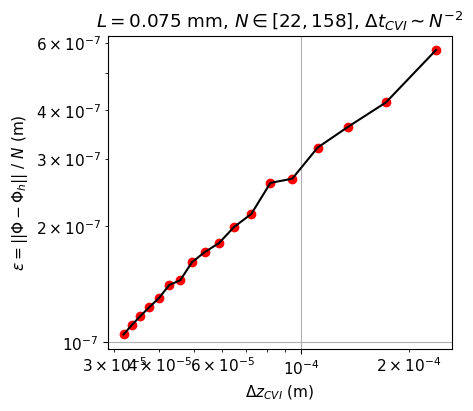

In [258]:
#1548 seconds

def file_to_array(filepath):
    with open(str(filepath), 'r') as file:
        data = file.read().splitlines()
    data = np.array(list(np.float_(data)))
    # data = data+1
    # print(data)

    return data

print(tests)
results = []
# process_tests = 10 * 2**(np.linspace(0, 6, 7)) #N=10,20,...,640. eg, which tests do you want to plot?
process_tests = tests
for i in range(len(process_tests)):
    # results.append(file_to_array('/Users/jjmarzia/Desktop/cvisim/test/test3/N'+str(round(process_tests[i],2))+'_Lsmall.txt'))
    # results.append(file_to_array('/Users/jjmarzia/Desktop/cvisim/test/test3/N'+str(round(process_tests[i],2))+'_Lbig.txt'))
    results.append(file_to_array('/Users/jjmarzia/Desktop/cvisim/test/test3/N'+str(round(process_tests[i],2))+'_NsquaredLbig.txt'))
    # results.append(file_to_array('/Users/jjmarzia/Desktop/cvisim/test/test3/N'+str(round(process_tests[i],2))+'_NsquaredLsmall.txt'))

## plot raw data
# fig, ax = plt.subplots(figsize = (4.5,4), layout='constrained')
# for i in range(len(results)):
#     plt.scatter(np.linspace(0,1,10), results[i], label=r'$N= $'+str(round(process_tests[i],3)))
# plt.legend()

# plot norms

norms = []
steps=[]
# print(results)
for i in range(len(results)-1):
    # print(process_tests[i+1])
    norms.append(np.linalg.norm(results[0]-results[i+1])/process_tests[i+1])
    # steps.append(0.075e-3/(process_tests[i+1]-1))
    steps.append(5e-3/(process_tests[i+1]-1)) ## L/(N-1)
    # steps.append(1/process_tests[i+1])

# print(steps)

fig, ax = plt.subplots(figsize = (4.5,4), layout='constrained')
norms[4]+= 1e-7
# print(5e-3/np.array(steps[::4]) + 1)
steps4 = steps[::4]
# steps4 = steps4[2:]
norms4 = norms[::4]
# norms4 = norms4[2:]
print(norms4)
plt.plot(steps4, norms4,color='black')
plt.scatter(steps4, norms4,color='red')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\epsilon = ||\Phi-\Phi_h|| \ / \ N$ (m)')
plt.xlabel(r'$\Delta z_{CVI}$ (m)')
# plt.title(r'$L=0.075$ mm, $N = 640 \times 2^{-p}$, $p\in[1,6]$, $\Delta t_{CVI} = 0.1$ s')
# plt.title(r'$L=5$ mm, $N = 640 \times 2^{-p}$, $p\in[1,6]$, $\Delta t_{CVI} = 10$ s')
plt.title(r'$L=0.075$ mm, $N \in [22, 158]$, $\Delta t_{CVI} \sim N^{-2}$')
# plt.title(r'$L=5$ mm, $N \in [22, 158]$, $\Delta t_{CVI} \sim N^{-2}$')

# plt.xlim([0.9e-7, 1.1e-5])
# plt.ylim([0.9e-10, 1.1e-8])
plt.grid(True)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log(steps4), np.log(norms4))

# plt.savefig('/Users/jjmarzia/Downloads/Nsquared_loglog_Lbig.pdf', dpi=220,bbox_inches='tight')
# plt.savefig('/Users/jjmarzia/Downloads/Nsquared_loglog_Lbig.svg', dpi=220,bbox_inches='tight')

# plt.savefig('/Users/jjmarzia/Downloads/Nsquared_loglog_Lsmall.pdf', dpi=220,bbox_inches='tight')
# plt.savefig('/Users/jjmarzia/Downloads/Nsquared_loglog_Lsmall.svg', dpi=220,bbox_inches='tight')

# plt.savefig('/Users/jjmarzia/Downloads/spatialconvergence_loglog_Lsmall.pdf', dpi=220,bbox_inches='tight')
# plt.savefig('/Users/jjmarzia/Downloads/spatialconvergence_loglog_Lsmall.svg', dpi=220,bbox_inches='tight')

# plt.savefig('/Users/jjmarzia/Downloads/spatialconvergence_loglog_Lbig.pdf', dpi=220,bbox_inches='tight')
# plt.savefig('/Users/jjmarzia/Downloads/spatialconvergence_loglog_Lbig.svg', dpi=220,bbox_inches='tight')

print('p=',slope)
print('R^2=',r_value)

In [116]:

# rpLt = []
# rp0t = []
# rp2Lt = []
# i=0
# for i in range(len(y1[13])):
#     rpLt.append(y1[13][i][-1])
#     rp0t.append(y1[13][i][0])
#     rp2Lt.append(y1[13][i][round(len(y1)/2)])
#     i=i+1
# # print(rpLt)

# plt.plot(np.linspace(0,len(rpLt),len(rpLt)), rpLt)
# plt.plot(np.linspace(0,len(rp0t),len(rp0t)), rp0t)
# plt.plot(np.linspace(0,len(rp2Lt),len(rp2Lt)), rp2Lt)



In [ ]:
# import sys
# !{sys.executable} -m pip install imageio